### Import Libraries

In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

2024-06-19 11:27:35.688354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 11:27:35.688459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 11:27:35.826805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Preprocessing

In [3]:
# Generate data paths with labels
train_dir = '/kaggle/input/capstone-dataset-children-autism/Autistic vs Non Autistic/Autistic vs Non Autistic/Train'
filepaths = []
labels = []

# Path to folders
folds = os.listdir(train_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(train_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,/kaggle/input/capstone-dataset-children-autism...,autistic
1,/kaggle/input/capstone-dataset-children-autism...,autistic
2,/kaggle/input/capstone-dataset-children-autism...,autistic
3,/kaggle/input/capstone-dataset-children-autism...,autistic
4,/kaggle/input/capstone-dataset-children-autism...,autistic
...,...,...
2521,/kaggle/input/capstone-dataset-children-autism...,non_autistic
2522,/kaggle/input/capstone-dataset-children-autism...,non_autistic
2523,/kaggle/input/capstone-dataset-children-autism...,non_autistic
2524,/kaggle/input/capstone-dataset-children-autism...,non_autistic


In [4]:
# Generate data paths with labels
val_dir = '/kaggle/input/capstone-dataset-children-autism/Autistic vs Non Autistic/Autistic vs Non Autistic/Valid'
filepaths = []
labels = []

# Path to folders
folds = os.listdir(val_dir)

# join path to folder and then path to each file, fyuhh
for fold in folds:
    foldpath = os.path.join(val_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

val_df = pd.concat([Fseries, Lseries], axis= 1)
val_df

,filepaths,labels
0,/kaggle/input/capstone-dataset-children-autism...,autistic
1,/kaggle/input/capstone-dataset-children-autism...,autistic
2,/kaggle/input/capstone-dataset-children-autism...,autistic
3,/kaggle/input/capstone-dataset-children-autism...,autistic
4,/kaggle/input/capstone-dataset-children-autism...,autistic
...,...,...
195,/kaggle/input/capstone-dataset-children-autism...,non_autistic
196,/kaggle/input/capstone-dataset-children-autism...,non_autistic
197,/kaggle/input/capstone-dataset-children-autism...,non_autistic
198,/kaggle/input/capstone-dataset-children-autism...,non_autistic


### Processing

In [5]:
# resize image
batch_size = 50
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

train_gen = ImageDataGenerator(
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        rescale=1./255,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='nearest')

val_gen = ImageDataGenerator(rescale=1.0/255.)

train_generator = train_gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'binary',
                                    color_mode= 'rgb', shuffle = True, batch_size = batch_size)

val_generator = val_gen.flow_from_dataframe(val_df, x_col= 'filepaths', y_col= 'labels', target_size = img_size, class_mode= 'binary', 
                                    color_mode= 'rgb', shuffle = False, batch_size = batch_size)

Found 2526 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [6]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.84):
      print("\nReached 84% accuracy so cancelling training!")
      self.model.stop_training = True

# MobileNetV2

In [7]:
from tensorflow.keras.applications import MobileNetV2
mob_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3),include_top = False, weights='imagenet')
mob_model.trainable = False

# last_layer = mob_model.get_layer('block_12_expand')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output

last_output = mob_model.output
print('last layer output shape: ', mob_model.output_shape)

9406464/9406464 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 1280)


In [8]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import MaxPooling2D

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

x = mob_model.output
# x = Dropout(0.2)(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((1,1))(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D(1,1)(x)
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs = mob_model.input, outputs = x)
model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])
# model.summary()

In [9]:
epochs = 100

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size

callback = myCallback()

history = model.fit(x = train_generator, epochs = epochs, steps_per_epoch = steps_per_epoch, verbose = 1, 
                    validation_data = val_generator, shuffle = False, callbacks = callback)

Epoch 1/100


I0000 00:00:1718796480.117639      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 59s 994ms/step - loss: 0.6351 - accuracy: 0.6536 - val_loss: 0.5994 - val_accuracy: 0.6700
Epoch 2/100
50/50 [==============================] - 32s 630ms/step - loss: 0.5319 - accuracy: 0.7420 - val_loss: 0.5188 - val_accuracy: 0.7650
Epoch 3/100
50/50 [==============================] - 31s 614ms/step - loss: 0.4989 - accuracy: 0.7516 - val_loss: 0.5213 - val_accuracy: 0.7650
Epoch 4/100
50/50 [==============================] - 31s 623ms/step - loss: 0.4957 - accuracy: 0.7632 - val_loss: 0.5057 - val_accuracy: 0.7750
Epoch 5/100
50/50 [==============================] - 32s 630ms/step - loss: 0.4754 - accuracy: 0.7672 - val_loss: 0.4930 - val_accuracy: 0.7800
Epoch 6/100
50/50 [==============================] - 31s 623ms/step - loss: 0.4633 - accuracy: 0.7892 - val_loss: 0.5810 - val_accuracy: 0.7550
Epoch 7/100
50/50 [==============================] - 32s 632ms/step - loss: 0.4443 - accuracy: 0.7912 - val_loss: 0.4885 - val_accuracy: 0.8000
Epoc

In [10]:
model.save('Model_Autistic.h5')

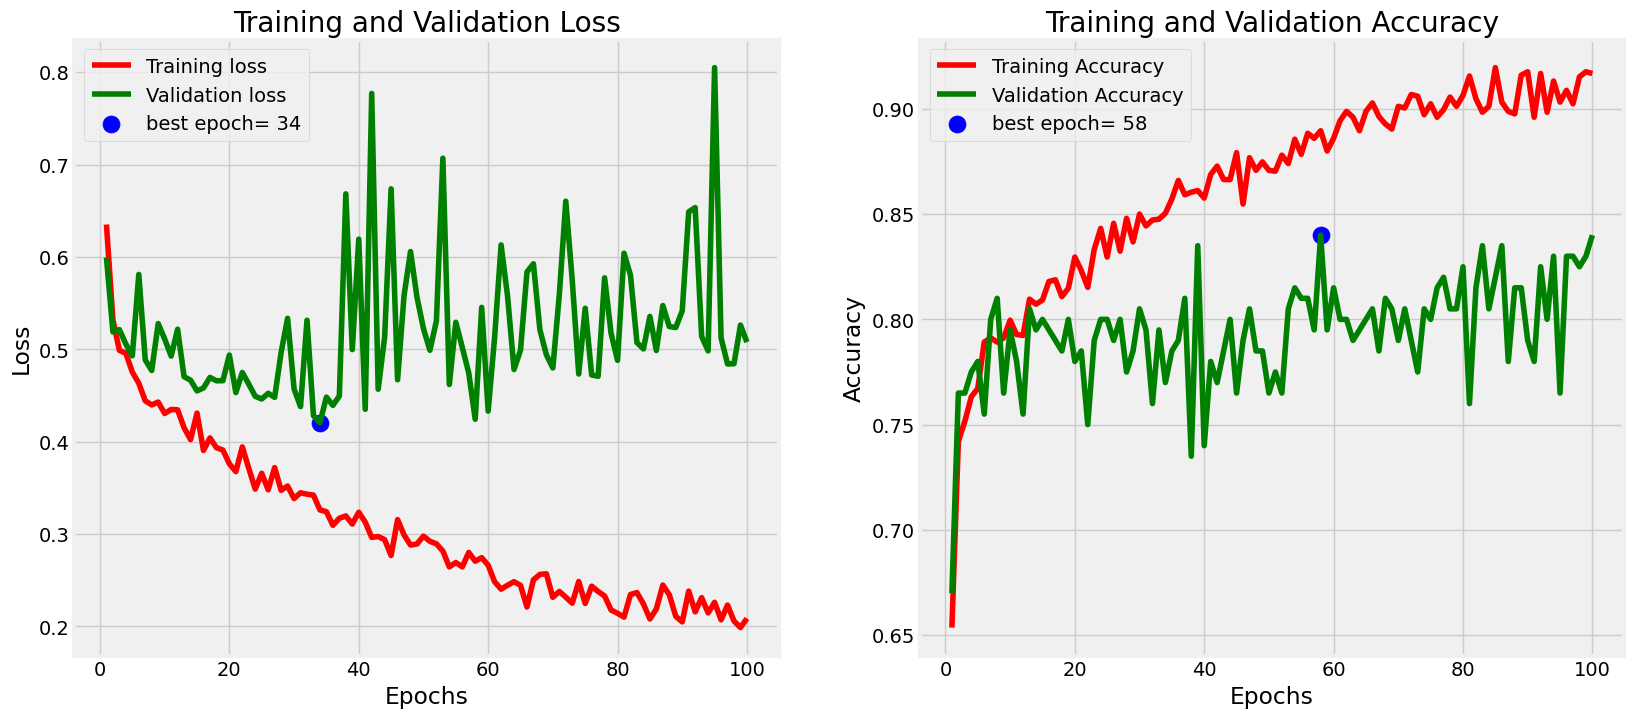

In [11]:
# Define needed variables
def f_history(history = history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

f_history(history)

In [12]:
preds = model.predict(val_generator)
y_pred = (preds > 0.5).astype(int).ravel()  

# Classification report
g_dict = val_generator.class_indices     
classes = list(g_dict.keys())       

print(classification_report(val_generator.classes, y_pred, target_names=classes))

4/4 [==============================] - 2s 151ms/step
              precision    recall  f1-score   support

    autistic       0.79      0.92      0.85       100
non_autistic       0.90      0.76      0.83       100

    accuracy                           0.84       200
   macro avg       0.85      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



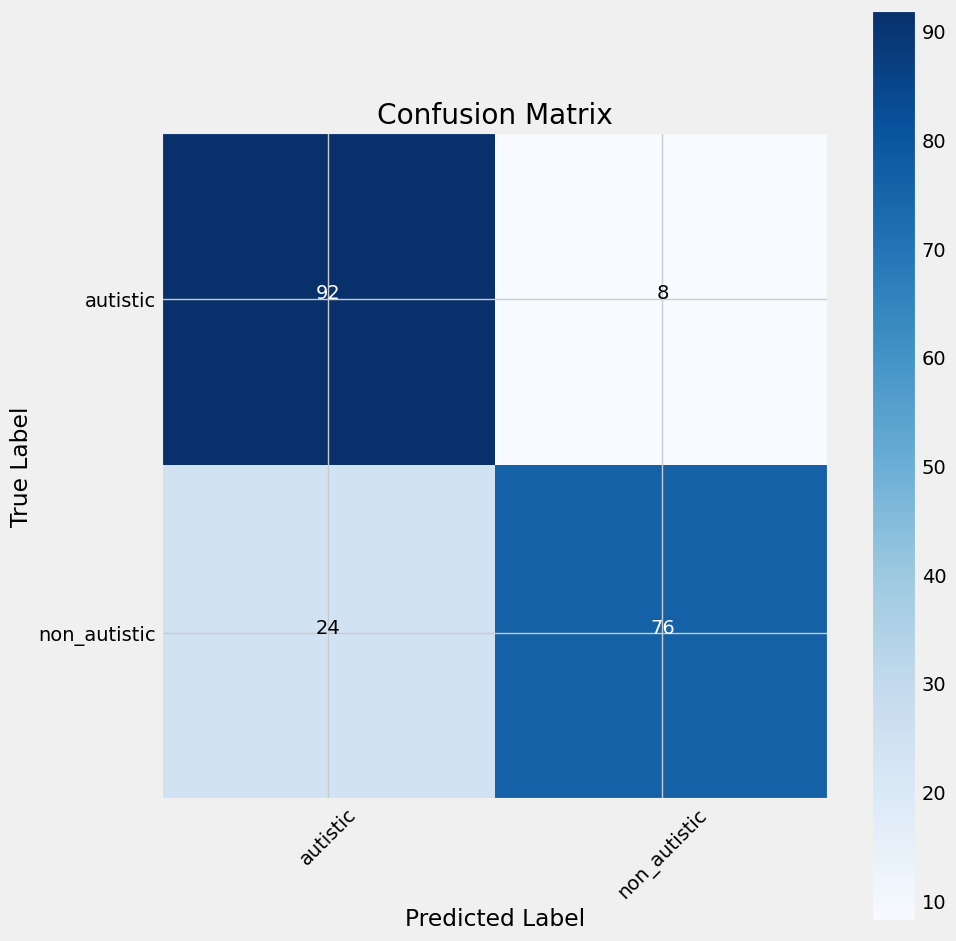

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

g_dict = val_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
def f_cm(y_pred):
    cm = confusion_matrix(val_generator.classes, y_pred)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

f_cm(y_pred)

In [14]:
!pip install tensorflowjs --upgrade

INFO: pip is looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of tensorstore to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: tensorstore
    Found existing installation: tensorstore 0.1.59
    Uninstalling tensorstore-0.1.59:
      Successful

In [15]:
!tensorflowjs_converter --input_format keras /kaggle/working/Model_Autistic.h5 /kaggle/working/autism_tfjs_model

2024-06-19 12:19:59.141661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 12:19:59.141727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 12:19:59.143299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
